TEXT

In [137]:
# IMPORTS
import random
import numpy as np
import pandas as pd

import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist, squareform
from sklearn.manifold import MDS

from deap import algorithms
from deap import base
from deap import creator
from deap import tools

from ProblemScripts import load_problem_KP

In [121]:
# Set random seed to ensure reproducibility
random.seed(37)

In [336]:
# n_items, capacity, optimal, values, weights, items_dict = load_problem_KP('f1_l-d_kp_10_269')
# n_items, capacity, optimal, values, weights, items_dict = load_problem_KP('f2_l-d_kp_20_878')
n_items, capacity, optimal, values, weights, items_dict = load_problem_KP('f8_l-d_kp_23_10000')
# n_items, capacity, optimal, values, weights, items_dict = load_problem_KP('knapPI_1_100_1000_1')

number of items: 23
max weight: 10000
values: [981 980 979 978 977 976 487 974 970 485 485 970 970 484 484 976 974 482
 962 961 959 958 857]
weights: [983 982 981 980 979 978 488 976 972 486 486 972 972 485 485 969 966 483
 964 963 961 958 959]
optimal solution: 9767


In [123]:
def knapsack_fitness(solution, values, weights, capacity):
    solution = np.array(solution)
    total_weight = np.dot(solution, weights)
    total_value = np.dot(solution, values)
    if total_weight > capacity:
        return 0  # Invalid solution
    return total_value

In [124]:
def generate_random_solution(length):
    return np.random.randint(2, size=length)

def generate_zero_solution(length):
    return np.zeros(length, dtype=int)

In [125]:
def generate_neighbors(solution):
    neighbors = []
    for i in range(len(solution)):
        neighbor = np.copy(solution)
        neighbor[i] = 1 - neighbor[i] # flip bit in new solution
        # if knapsack_fitness(neighbor, values, weights, capacity) != 0:
        neighbors.append(neighbor)
    return neighbors

In [126]:
def hill_climbing_with_LTN():
    # sol = generate_random_solution(n_items)
    sol = generate_zero_solution(n_items)
    fit = knapsack_fitness(sol, values, weights, capacity)
    trajectory = []  # Track nodes (solutions) visited
    transitions = []  # Track edges (transitions between solutions)
    
    while True:
        neighbors = generate_neighbors(sol)
        neighbors_fits = []
        for neighbor in neighbors:
            neighbors_fits.append(knapsack_fitness(neighbor, values, weights, capacity))
        
        next_sol_index = np.argmax(neighbors_fits)
        next_sol = neighbors[next_sol_index]
        next_fit = neighbors_fits[next_sol_index]
        
        trajectory.append(tuple(sol))  # Record the current solution
        
        if next_fit <= fit:
            break

        # Record the transition (current solution -> next solution)
        transitions.append((tuple(sol), tuple(next_sol), next_fit - fit))
        
        sol, fit = next_sol, next_fit

    return tuple(sol), trajectory, transitions



In [127]:
def create_LTN(trajectory, transitions):
    G = nx.DiGraph()

    # Add nodes (solutions)
    for sol in set([node for gen in trajectory for node in gen]):
        G.add_node(sol)

    # Add edges (transitions)
    for transition in transitions:
        src, dest, weight = transition
        G.add_edge(src, dest, weight=weight)

    # Plot the LTN
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=False, node_size=50, font_size=8)
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    plt.show()


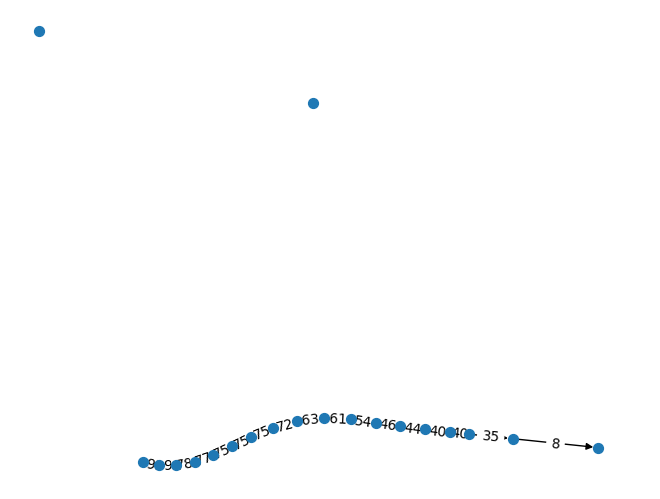

In [128]:
sol, trajectory, transitions = hill_climbing_with_LTN()
create_LTN(trajectory, transitions)

In [129]:
def hill_climbing_multiple_runs(n_runs):
    all_trajectories = []
    all_transitions = []

    for _ in range(n_runs):
        sol, trajectory, transitions = hill_climbing_with_LTN()  # Use the hill climbing with LTN version
        all_trajectories.extend(trajectory)
        all_transitions.extend(transitions)

    return all_trajectories, all_transitions

In [130]:
def create_combined_LTN(trajectories, transitions):
    G = nx.DiGraph()

    # Add nodes (solutions) from all trajectories
    unique_nodes = set()
    for sol in set([node for traj in trajectories for node in traj]):
        print(sol)
        unique_nodes.add(sol)
        G.add_node(sol)

    # Add edges (transitions) from all runs
    for transition in transitions:
        src, dest, weight = transition
        if G.has_edge(src, dest):
            G[src][dest]['weight'] += weight  # Accumulate weights if the edge already exists
        else:
            G.add_edge(src, dest, weight=weight)

    # Plot the combined LTN
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=False, node_size=50, font_size=8)
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    plt.show()

In [135]:
all_trajectories, all_transitions = hill_climbing_multiple_runs(100)
print(all_trajectories)
print(all_transitions)

[(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), (0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), (0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), (0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0), (0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0), (0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0), (0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0), (0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0), (0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0), (0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1), (0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1), (0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1), (0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1), (1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1), (1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1), (1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1), (1, 1, 

0
1


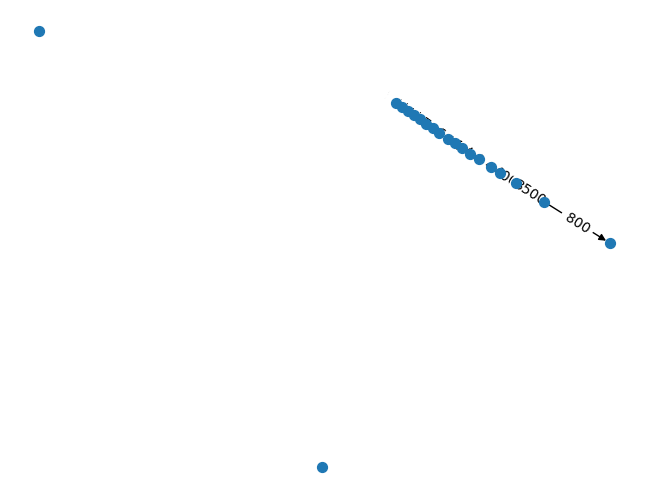

In [136]:
create_combined_LTN(all_trajectories, all_transitions)

In [14]:
def evalIndividual(individual):
    weight = 0
    value = 0
    # print(individual)
    for i in range(n_items):
        value += items_dict[i][0] * individual[i]
        weight += items_dict[i][1] * individual[i]
    if weight > capacity:
        return (0,)
    # print(value)
    return (value,)

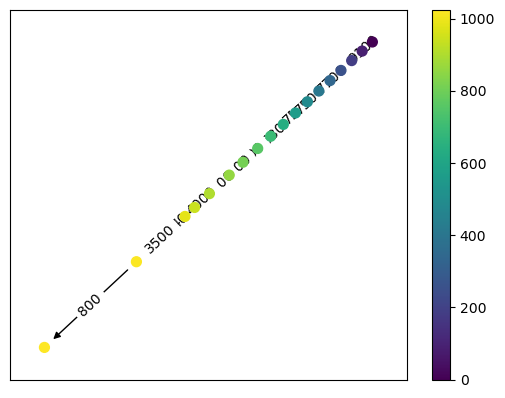

In [133]:
def create_combined_LTN_with_fitness(trajectories, transitions, values, weights, capacity):
    G = nx.DiGraph()

    unique_solutions = set(trajectories)
    
    # Add nodes (solutions) with fitness information
    for sol in unique_solutions:
        # print(sol)
        fitness = knapsack_fitness(sol, values, weights, capacity)
        G.add_node(sol, fitness=fitness)

    # Add edges (transitions) from all runs
    for transition in transitions:
        src, dest, weight = transition
        if G.has_edge(src, dest):
            G[src][dest]['weight'] += weight  # Accumulate weights if the edge already exists
        else:
            G.add_edge(src, dest, weight=weight)

    # Plot the combined LTN
    pos = nx.spring_layout(G)
    
    # Node colors based on fitness
    node_colors = [G.nodes[node]['fitness'] for node in G.nodes()]
    nodes = nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.viridis, node_size=50)
    edges = nx.draw_networkx_edges(G, pos)
    
    # Add colorbar
    plt.colorbar(nodes)
    
    # Add labels to the edges
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    
    plt.show()

create_combined_LTN_with_fitness(all_trajectories, all_transitions, values, weights, capacity)

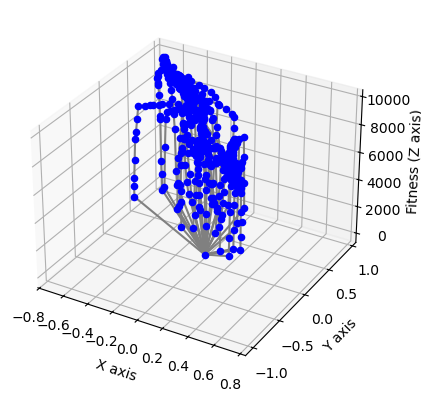

In [357]:
def create_3d_LTN_with_fitness(trajectories, transitions, values, weights, capacity):
    G = nx.DiGraph()

    # Convert the solution tuples to a set of unique solutions
    unique_solutions = set(trajectories)

    # Add nodes (solutions) with fitness information
    for sol in unique_solutions:
        # Convert each tuple to a numpy array for fitness calculation
        fitness = knapsack_fitness(sol, values, weights, capacity)
        # fitness = evalIndividual(sol)
        G.add_node(sol, fitness=fitness)

    # Add edges (transitions) from all runs
    for transition in transitions:
        src, dest, weight = transition
        if G.has_edge(src, dest):
            G[src][dest]['weight'] += weight  # Accumulate weights if the edge already exists
        else:
            G.add_edge(src, dest, weight=weight)

    # Now that the nodes are added to the graph, calculate 2D positions for them
    pos_2d = nx.spring_layout(G, dim=2)  # Use spring layout for node positions in 2D

    # Create a 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Extract node positions and fitness values
    for node, (x, y) in pos_2d.items():
        z = G.nodes[node]['fitness']  # Get the fitness as the z-coordinate
        ax.scatter(x, y, z, c='b', marker='o')  # Plot nodes in 3D

    # Add edges to the plot
    for src, dest in G.edges():
        x_vals = [pos_2d[src][0], pos_2d[dest][0]]
        y_vals = [pos_2d[src][1], pos_2d[dest][1]]
        z_vals = [G.nodes[src]['fitness'], G.nodes[dest]['fitness']]
        ax.plot(x_vals, y_vals, z_vals, 'gray')  # Draw edges

    # Label axes
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Fitness (Z axis)')

    # Show the plot
    plt.show()

# Call this function with trajectories, transitions, and knapsack parameters
create_3d_LTN_with_fitness(all_trajectories, all_transitions, values, weights, capacity)

In [298]:
def zeros_individual():
        return creator.Individual([0] * n_items)

def ones_individual():
        return creator.Individual([1] * n_items)

def BasicEA_TT(pop_size, n_generations, starting_sol=None):
    # Create fitness class
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    # weights is positive to signify maximisation of fitness, use negative to minimise
    # weights must be a tuple to allow to single and multi objective problems
    # to be treated in the same way

    # create individual class
    creator.create("Individual", list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox() # Initialise DEAP toolbox
    toolbox.register("attr_int", random.randint, 0, 1) # generate atributes of 0 or 1
    
    # initialise starting solution as 0's, 1's, or random
    if starting_sol ==  0:
         toolbox.register("individual", zeros_individual)
    elif starting_sol == 1:
        toolbox.register("individual", ones_individual)
    else:
        toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, n=n_items)

    toolbox.register("population", tools.initRepeat, list, toolbox.individual) # initialise population

    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
    # toolbox.register("select", tools.selBest)
    toolbox.register("select", tools.selTournament, tournsize=10)
    toolbox.register("evaluate", evalIndividual)

    # cxpb, mutpb = 0.5, 0.2  # Number of generations, crossover probability, mutation probability
    cxpb, mutpb = 0, 0.2  # crossover probability, mutation probability
    
    # Initialize population and evaluate fitness
    population = toolbox.population(pop_size)
    fits = [toolbox.evaluate(ind)[0] for ind in population]
    for ind, fit in zip(population, fits):
        ind.fitness.values = (fit,)

    # Initialize tracking variables
    best_ind = tools.selBest(population, 1)[0]
    best_fitness = best_ind.fitness.values[0]
    trajectory = [tuple(best_ind)]
    transitions = []

    evaluations = {}       # Tracks the number of evaluations needed for each solution
    stuck_durations = {}   # Tracks how long the algorithm was "stuck" at each solution

    current_stuck_duration = 0
    eval_count = 0

    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", lambda x: sum(f[0] for f in x) / len(x))
    stats.register("max", lambda x: max(f[0] for f in x))

    gen = 0
    for gen in range(n_generations):
        # Apply crossover and mutation
        population = algorithms.varAnd(population, toolbox, cxpb, mutpb)
        fits = [toolbox.evaluate(ind)[0] for ind in population]
        eval_count += len(population)  # Count evaluations in the current generation

        # Update fitness of individuals
        for ind, fit in zip(population, fits):
            ind.fitness.values = (fit,)

        # Find the best individual in the current generation
        current_best = tools.selBest(population, 1)[0]
        current_best_fitness = current_best.fitness.values[0]

        if current_best_fitness > best_fitness:
            # Update evaluations and stuck durations for the previous best
            if tuple(best_ind) not in evaluations:
                evaluations[tuple(best_ind)] = eval_count
                stuck_durations[tuple(best_ind)] = current_stuck_duration
            else:
                evaluations[tuple(best_ind)] = min(evaluations[tuple(best_ind)], eval_count)
                stuck_durations[tuple(best_ind)] = max(stuck_durations[tuple(best_ind)], current_stuck_duration)

            # Record transition and reset stuck duration
            transitions.append((tuple(best_ind), tuple(current_best), current_best_fitness - best_fitness))
            trajectory.append(tuple(current_best))
            best_ind = current_best
            best_fitness = current_best_fitness
            current_stuck_duration = 0  # Reset stuck duration for the new best
        else:
            current_stuck_duration += 1  # Increment if the best solution did not improve

        # Update Hall of Fame
        hof.update(population)
        
        # Select next generation
        population = toolbox.select(population, len(population))

    # After the loop, store evaluations and stuck duration for the final best individual
    if tuple(best_ind) not in evaluations:
        evaluations[tuple(best_ind)] = eval_count
        stuck_durations[tuple(best_ind)] = current_stuck_duration
    else:
        evaluations[tuple(best_ind)] = min(evaluations[tuple(best_ind)], eval_count)
        stuck_durations[tuple(best_ind)] = max(stuck_durations[tuple(best_ind)], current_stuck_duration)

    # Prepare `evaluations` and `stuck_durations` lists for plotting function
    unique_trajectory = list(set(trajectory))
    evals_list = [evaluations[sol] for sol in unique_trajectory]
    stuck_list = [stuck_durations[sol] for sol in unique_trajectory]

    best_ind = hof[0]
    print(f"Best individual: {best_ind}, Value: {evalIndividual(best_ind)[0]}")

    return trajectory, transitions, evals_list, stuck_list

In [227]:
print(f'Optimal Solution: {optimal}')
trajectory, transitions, evals_list, stuck_list = BasicEA_TT(10, 100)

Optimal Solution: 1024
Best individual: [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1], Value: 958


c:\Users\Admin\anaconda3\envs\EA\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\Admin\anaconda3\envs\EA\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [228]:
print(trajectory)
print(len(trajectory))
print(trajectory[0])
print(trajectory[1])
print(trajectory[2])

[(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), (0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), (0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0), (1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0), (1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0), (1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0), (1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0), (1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0), (1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0), (1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0), (1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0), (1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0), (1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0), (1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0), (1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0), (1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0), (1, 1, 

In [229]:
print(transitions)
print(len(transitions))
print(transitions[0])
print(transitions[1])
print(transitions[2])

[((0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), (0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), 150.0), ((0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), (0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0), 153.0), ((0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0), (1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0), 4.0), ((1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0), (1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0), 91.0), ((1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0), (1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0), 147.0), ((1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0), (1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0), 40.0), ((1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0), (1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0), 15.0), ((1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0), (1, 1, 0, 

In [230]:
print(evals_list)
print(stuck_list)

[40, 360, 200, 210, 70, 60, 10, 250, 90, 170, 430, 610, 1000, 50, 640, 20, 370, 280]
[1, 7, 2, 0, 0, 0, 0, 3, 1, 7, 5, 17, 36, 0, 2, 0, 0, 2]


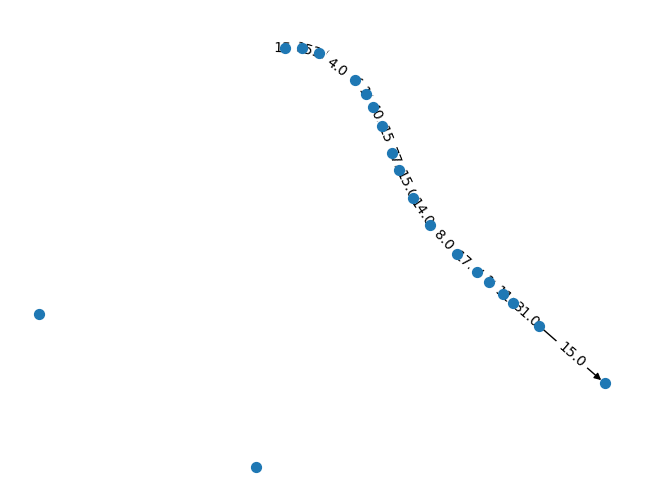

In [231]:
create_LTN(trajectory, transitions)

In [290]:
def BasicEA_TT_multiple_runs(n_runs):
    all_trajectories = []
    all_transitions = []
    all_evals = []
    all_stuck = []

    for _ in range(n_runs):
        trajectory, transitions, evals_list, stuck_list = BasicEA_TT(100, 1000, starting_sol=0)  # Use the hill climbing with LTN version
        all_trajectories.extend(trajectory)
        all_transitions.extend(transitions)
        all_evals.extend(evals_list)
        all_stuck.extend(stuck_list)

    return all_trajectories, all_transitions, all_evals, all_stuck

def BasicEA_TT_multiple_runs_10(n_runs):
    all_trajectories = []
    all_transitions = []
    all_evals = []
    all_stuck = []

    for _ in range(n_runs):
        trajectory, transitions, evals_list, stuck_list = BasicEA_TT(100, 1000, starting_sol=0)  # Use the hill climbing with LTN version
        all_trajectories.extend(trajectory)
        all_transitions.extend(transitions)
        all_evals.extend(evals_list)
        all_stuck.extend(stuck_list)
    
    for _ in range(n_runs):
        trajectory, transitions, evals_list, stuck_list = BasicEA_TT(100, 1000, starting_sol=1)  # Use the hill climbing with LTN version
        all_trajectories.extend(trajectory)
        all_transitions.extend(transitions)
        all_evals.extend(evals_list)
        all_stuck.extend(stuck_list)

    return all_trajectories, all_transitions, all_evals, all_stuck

In [343]:
print(optimal)
all_trajectories, all_transitions, all_evals, all_stuck = BasicEA_TT_multiple_runs(30)

9767


c:\Users\Admin\anaconda3\envs\EA\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\Admin\anaconda3\envs\EA\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Best individual: [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0], Value: 9767
Best individual: [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0], Value: 9767
Best individual: [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0], Value: 9767
Best individual: [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0], Value: 9767
Best individual: [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0], Value: 9767
Best individual: [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0], Value: 9767
Best individual: [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0], Value: 9767
Best individual: [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0], Value: 9767
Best individual: [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0], Value: 9767
Best individual: [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0], Value: 9767


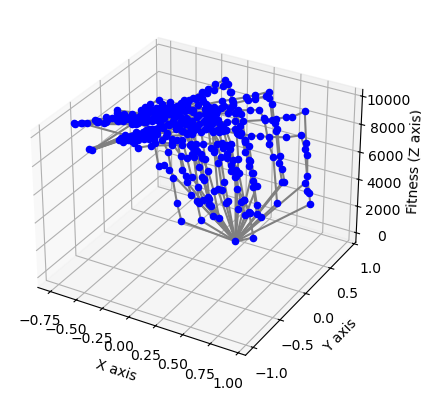

In [359]:
create_3d_LTN_with_fitness(all_trajectories, all_transitions, values, weights, capacity)

In [352]:
# def calc_distance(opt1, opt2):
#     return sum(1 for i in range(len(opt1)) if opt1[i] != opt2[i])

def hamming_distance(sol1, sol2):
    return sum(el1 != el2 for el1, el2 in zip(sol1, sol2))

def create_3d_MDS_LTN_with_fitness(trajectories, transitions, values, weights, capacity):
    G = nx.DiGraph()
    unique_solutions = list(set(trajectories))

    # Add nodes with fitness information
    for sol in unique_solutions:
        fitness = knapsack_fitness(sol, values, weights, capacity)
        # fitness = evalIndividual(sol)
        G.add_node(sol, fitness=fitness)

    # Compute Hamming distances between all unique solutions
    hamming_distances = squareform(pdist(np.array(unique_solutions), metric=lambda u, v: hamming_distance(tuple(u), tuple(v))))

    # Apply MDS for 2D coordinates based on Hamming distances
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
    pos_2d = mds.fit_transform(hamming_distances)

    # Create a mapping from solution to 2D position
    pos_map = {sol: (x, y) for sol, (x, y) in zip(unique_solutions, pos_2d)}

    # Add edges with weights from transitions
    for src, dest, weight in transitions:
        if G.has_edge(src, dest):
            G[src][dest]['weight'] += weight
        else:
            G.add_edge(src, dest, weight=weight)

    # Create a 3D plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot nodes with fitness as the z-axis coordinate
    for node in G.nodes():
        x, y = pos_map[node]
        z = G.nodes[node]['fitness']
        ax.scatter(x, y, z, c='b', marker='o')

    # Add edges to the plot
    for src, dest in G.edges():
        x_vals = [pos_map[src][0], pos_map[dest][0]]
        y_vals = [pos_map[src][1], pos_map[dest][1]]
        z_vals = [G.nodes[src]['fitness'], G.nodes[dest]['fitness']]
        ax.plot(x_vals, y_vals, z_vals, 'gray')

    # Label axes
    ax.set_xlabel('MDS X axis (Similarity-based)')
    ax.set_ylabel('MDS Y axis (Similarity-based)')
    ax.set_zlabel('Fitness (Z axis)')

    plt.show()

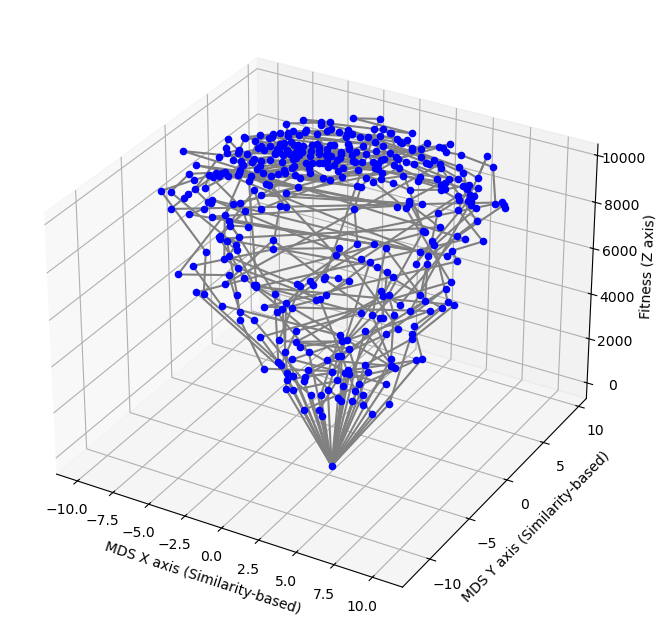

In [360]:
create_3d_MDS_LTN_with_fitness(all_trajectories, all_transitions, values, weights, capacity)

In [361]:
def create_3d_MDS_coloured(trajectories, transitions, values, weights, capacity, evaluations, stuck_durations):
    G = nx.DiGraph()
    unique_solutions = list(set(trajectories))

    # Add nodes with fitness, evaluations, and stuck duration information
    for sol in unique_solutions:
        fitness = knapsack_fitness(sol, values, weights, capacity)
        # fitness = evalIndividual(sol)
        eval_count = evaluations[trajectories.index(sol)]  # Get evaluations count for solution
        stuck_duration = stuck_durations[trajectories.index(sol)]  # Get stuck duration for solution
        G.add_node(sol, fitness=fitness, evaluations=eval_count, stuck_duration=stuck_duration)

    # Compute Hamming distances and apply MDS as before
    hamming_distances = squareform(pdist(np.array(unique_solutions), metric=lambda u, v: hamming_distance(tuple(u), tuple(v))))
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
    pos_2d = mds.fit_transform(hamming_distances)
    pos_map = {sol: (x, y) for sol, (x, y) in zip(unique_solutions, pos_2d)}

    # Create a color map and scale for node size
    evals_array = np.array([G.nodes[node]['evaluations'] for node in G.nodes()])
    stuck_array = np.array([G.nodes[node]['stuck_duration'] for node in G.nodes()])
    norm = plt.Normalize(vmin=evals_array.min(), vmax=evals_array.max())
    colors = plt.cm.viridis(norm(evals_array))  # Normalize colors

    sizes = 15 + 45 * (stuck_array - stuck_array.min()) / (stuck_array.max() - stuck_array.min())  # Normalize sizes

    # Create 3D plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot nodes with color and size based on evaluations and stuck durations
    for idx, node in enumerate(G.nodes()):
        x, y = pos_map[node]
        z = G.nodes[node]['fitness']
        ax.scatter(x, y, z, c=[colors[idx]], s=sizes[idx], marker='o')  # Use colors and sizes

    # Add edges from transitions to the plot
    for src, dest, weight in transitions:
        x_vals = [pos_map[src][0], pos_map[dest][0]]
        y_vals = [pos_map[src][1], pos_map[dest][1]]
        z_vals = [G.nodes[src]['fitness'], G.nodes[dest]['fitness']]
        ax.plot(x_vals, y_vals, z_vals, 'gray')  # Adjust color or style as needed
    
    # Add colorbar to indicate the evaluations count
    mappable = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.viridis)
    mappable.set_array(evals_array)
    fig.colorbar(mappable, ax=ax, shrink=0.5, aspect=10, label='fitness evaluations')

    ax.view_init(elev=0, azim=45)

    # Label axes
    ax.set_xlabel('MDS X axis (Similarity-based)')
    ax.set_ylabel('MDS Y axis (Similarity-based)')
    ax.set_zlabel('Fitness (Z axis)')
    plt.show()

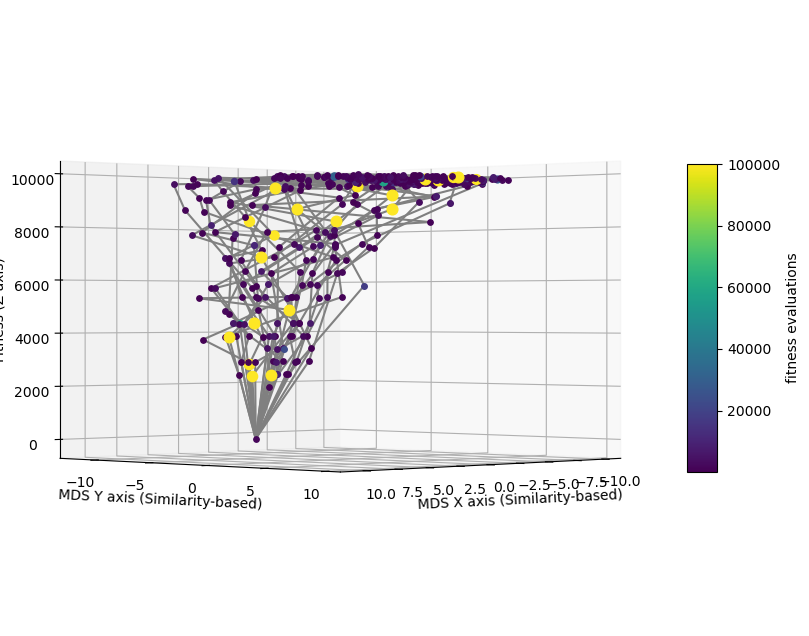

In [362]:
create_3d_MDS_coloured(all_trajectories, all_transitions, values, weights, capacity, all_evals, all_stuck)